In [ ]:
# adapt nuleotide_dependency_maps (NDMs) to Genomic Pre-trained Network (GPN)

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# gpn specific
import gpn.model
from transformers import AutoModel, AutoModelForMaskedLM, AutoTokenizer

# ndm spcific
from transformers import DefaultDataCollator
from datasets import Dataset

In [4]:
model_path = "songlab/gpn-brassicales"

Example region: chr5:3566900-3567600

[UCSC Genome Browser view](https://genome.ucsc.edu/cgi-bin/hgTracks?db=hub_2660163_GCF_000001735.4&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr5%3A3566900%2D3567600&hgsid=1597075775_CFnbwi2A0U0D8AuOgfJ0LsbUXnOb)

In [2]:
seq = "CGGGTTAAAAATCTAGTTGTTATTATTAAAGGAAATAAAATATCCTCATAAAACAATTTGTTGTAATCTATCTTTGGGCTAATGTTCTTATCCTACAAGACGAACCCTGACCGTATTCGTCGTAGAAAAAAAATTGCTTCGATCCCATCATTGAGTTCAATAATCGGCGCACAAAGGCCGATTCATAAAAACTCTAGGCCCATTAAAGTAAAGCCCATTCTCAACCCTATCCAGTCTCCCTGTATATATATATTTACGACACCAACCCAGCGTTGATATTTAATTTTCTTCAGTCAGAGATTTCGAAACCCTAGTCGATTTCGAGATCCAACTAACTCTGCTCCTTATCTCAGGTAAAATTCTCGCTCGAGAACTCAATTGCTTATCCAAAGTTCCAACTGAAGATGCTTTCCTACTGAATCTTAGGTTAATGTTTTGGATTTGGAATCTTACCCGAAATTTCTCTGCAGCTTGTTGAATTTGCGAAGTATGGGAGACGCTAGAGACAACGAAGCCTACGAGGAGGAGCTCTTGGACTATGAAGAAGAAGACGAGAAGGTCCCAGATTCTGGAAACAAAGTTAACGGCGAAGCTGTGAAAAAGTGAGTTTTATGGTTTCCTCGATATGTTTCATGTATACTACTGTGTGTTTAAATTTGTCGATTCTTAGATTACTACTTGATAACAAGTAGCAGTATGT"
len(seq)

700

In [5]:
tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.get_vocab()

{'[MASK]': 1, 'g': 5, 't': 6, '[PAD]': 0, '[UNK]': 2, 'a': 3, 'c': 4}

In [52]:
# model = AutoModel.from_pretrained(model_path)
model = AutoModelForMaskedLM.from_pretrained(model_path)
device = "cuda"
model.to(device)
model.eval()

ConvNetForMaskedLM(
  (model): ConvNetModel(
    (embedding): GPNEmbedding()
    (encoder): Sequential(
      (0): ConvLayer(
        (conv): Sequential(
          (0): TransposeLayer()
          (1): Conv1d(512, 512, kernel_size=(9,), stride=(1,), padding=same)
          (2): TransposeLayer()
          (3): GELU(approximate='none')
          (4): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )
        (ffn): Sequential(
          (0): Linear(in_features=512, out_features=512, bias=True)
          (1): GELU(approximate='none')
          (2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )
      )
      (1): ConvLayer(
        (conv): Sequential(
          (0): TransposeLayer()
          (1): Conv1d(512, 512, kernel_size=(9,), stride=(1,), padding=same, dilation=(2,))
          (2): TransposeLayer()
          (3): GELU(approximate='none')
          (4): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )
        (ffn): Sequential(
          (0

In [41]:
# dependency map generation functions

nuc_table = {"A": 0, "C": 1, "G": 2, "T": 3}


def mutate_sequence(seq):

    seq = seq.upper()
    mutated_sequences = {"seq": [], "mutation_pos": [], "nuc": [], "var_nt_idx": []}
    mutated_sequences["seq"].append(seq)
    mutated_sequences["mutation_pos"].append(-1)
    mutated_sequences["nuc"].append("real sequence")
    mutated_sequences["var_nt_idx"].append(-1)

    mutate_until_position = len(seq)

    for i in range(mutate_until_position):
        for nuc in ["A", "C", "G", "T"]:
            if nuc != seq[i]:
                mutated_sequences["seq"].append(seq[:i] + nuc + seq[i + 1 :])
                mutated_sequences["mutation_pos"].append(i)
                mutated_sequences["nuc"].append(nuc)
                mutated_sequences["var_nt_idx"].append(nuc_table[nuc])

    mutations_df = pd.DataFrame(mutated_sequences)

    return mutations_df


def create_dataloader(dataset, batch_size=64, rolling_masking=False):

    ds = Dataset.from_pandas(dataset[["seq"]])

    # print(ds.shape)
    
    tok_ds = ds.map(lambda x: tokenizer(list(x["seq"]), return_tensors="pt", return_attention_mask=False, return_token_type_ids=False), batched=False, num_proc=20)

    # print(tok_ds.shape)
    
    rem_tok_ds = tok_ds.remove_columns("seq")

    # print(rem_tok_ds.shape)

    data_collator = DefaultDataCollator()

    data_loader = torch.utils.data.DataLoader(
        rem_tok_ds,
        batch_size=batch_size,
        num_workers=4,
        shuffle=False,
        collate_fn=data_collator,
    )

    return data_loader

In [42]:
dataset = mutate_sequence(seq)
dataset

,seq,mutation_pos,nuc,var_nt_idx
0,CGGGTTAAAAATCTAGTTGTTATTATTAAAGGAAATAAAATATCCT...,-1,real sequence,-1
1,AGGGTTAAAAATCTAGTTGTTATTATTAAAGGAAATAAAATATCCT...,0,A,0
2,GGGGTTAAAAATCTAGTTGTTATTATTAAAGGAAATAAAATATCCT...,0,G,2
3,TGGGTTAAAAATCTAGTTGTTATTATTAAAGGAAATAAAATATCCT...,0,T,3
4,CAGGTTAAAAATCTAGTTGTTATTATTAAAGGAAATAAAATATCCT...,1,A,0
...,...,...,...,...
2096,CGGGTTAAAAATCTAGTTGTTATTATTAAAGGAAATAAAATATCCT...,698,C,1
2097,CGGGTTAAAAATCTAGTTGTTATTATTAAAGGAAATAAAATATCCT...,698,T,3
2098,CGGGTTAAAAATCTAGTTGTTATTATTAAAGGAAATAAAATATCCT...,699,A,0
2099,CGGGTTAAAAATCTAGTTGTTATTATTAAAGGAAATAAAATATCCT...,699,C,1


In [49]:
data_loader = create_dataloader(dataset, batch_size=1)
data_loader

Map (num_proc=20):   0%|          | 0/2101 [00:00<?, ? examples/s]

In [ ]:
# sample = next(iter(data_loader))['input_ids']
# print(sample.shape)
# sample
# question: the data prepared like this does not contain any [MASK] token (id 1).
# do Silva et al. similarly not explicitly mask a token or am I just missing the respective part in their data preparation?
# also check again in their corresponding paper how they describe the method
# ==> They explicitly state, there is _no_ masking when computing the variant influence score

In [56]:
acgt_idxs = [tokenizer.get_vocab()[nuc] for nuc in ['a', 'c', 'g', 't']]

def model_inference(model, data_loader):

    output_arrays = []
    for i, batch in enumerate(data_loader):
        # get some tokenized sequences (B, L_in)
        
        tokens = batch['input_ids']

        print(tokens.shape)
        
        tokens = torch.squeeze(tokens, dim=2)

        print(tokens.shape)
        # predict
        with torch.autocast(device):
            with torch.no_grad():
                # ORIGINAL
                # outputs = model(tokens.to(device)).prediction_logits.cpu().to(torch.float32)
                # APATED
                outputs = model(input_ids=tokens.to(device)).logits.cpu().to(torch.float32)
        output_probs = torch.nn.functional.softmax(outputs, dim=-1)[:,:,acgt_idxs] # B, L_seq, 4
        output_arrays.append(output_probs) 

    # rebuild to B, L_seq, 4
    snp_reconstruct = torch.concat(output_arrays, axis=0)

    return snp_reconstruct.to(torch.float32).numpy()

def compute_dependency_map(seq, proxy_species, epsilon=1e-10):

    dataset = mutate_sequence(seq) 
    data_loader = create_dataloader(dataset)
    snp_reconstruct = model_inference(model, data_loader)

    # those tokens do not esist for GPN
    # snp_reconstruct = snp_reconstruct[:,2:-1,:] # discard the beginning of sentence token, species token and end of sentence token
    

     # for the logit add a small value epsilon and renormalize such that every prob in one position sums to 1
    snp_reconstruct = snp_reconstruct + epsilon
    snp_reconstruct = snp_reconstruct/snp_reconstruct.sum(axis=-1)[:,:, np.newaxis]

    seq_len = snp_reconstruct.shape[1]
    snp_effect = np.zeros((seq_len, seq_len,4, 4))
    reference_probs = snp_reconstruct[dataset[dataset['nuc'] == 'real sequence'].index[0]]

    
    snp_effect[dataset.iloc[1:]['mutation_pos'].values, : ,  dataset.iloc[1:]['var_nt_idx'].values,:] = np.log2(snp_reconstruct[1:]) - np.log2(1 - snp_reconstruct[1:]) \
        - np.log2(reference_probs) + np.log2(1-reference_probs)

    dep_map = np.max(np.abs(snp_effect), axis=(2,3))
    #zero main diagonal values
    dep_map[np.arange(dep_map.shape[0]), np.arange(dep_map.shape[0])] = 0

    return dep_map

In [ ]:
snp_reconstruct = model_inference(model, data_loader)

In [59]:
snp_reconstruct[0].shape

(700, 4)

In [61]:
epsilon=1e-10

In [62]:
snp_reconstruct = snp_reconstruct + epsilon

In [63]:
snp_reconstruct = snp_reconstruct/snp_reconstruct.sum(axis=-1)[:,:, np.newaxis]

In [64]:
snp_reconstruct[0]

array([[0.04054989, 0.82729226, 0.07862128, 0.05353658],
       [0.02927173, 0.12783536, 0.80755   , 0.03534294],
       [0.05227411, 0.11100253, 0.78984225, 0.04688109],
       ...,
       [0.10750337, 0.02164952, 0.09186275, 0.77898437],
       [0.0949696 , 0.13445279, 0.6547287 , 0.11584897],
       [0.1171826 , 0.04456446, 0.05600563, 0.7822473 ]], dtype=float32)

In [65]:
seq_len = snp_reconstruct.shape[1]

In [66]:
seq_len

700

In [67]:
snp_effect = np.zeros((seq_len, seq_len,4, 4))

In [68]:
reference_probs = snp_reconstruct[dataset[dataset['nuc'] == 'real sequence'].index[0]]

In [69]:
reference_probs[0]

array([0.04054989, 0.82729226, 0.07862128, 0.05353658], dtype=float32)

In [70]:
snp_effect[dataset.iloc[1:]['mutation_pos'].values, : ,  dataset.iloc[1:]['var_nt_idx'].values,:] = np.log2(snp_reconstruct[1:]) - np.log2(1 - snp_reconstruct[1:]) - np.log2(reference_probs) + np.log2(1-reference_probs)

In [72]:
snp_effect.shape

(700, 700, 4, 4)

In [73]:
dep_map = np.max(np.abs(snp_effect), axis=(2,3))

In [74]:
dep_map[np.arange(dep_map.shape[0]), np.arange(dep_map.shape[0])] = 0

In [76]:
## Visualization functions

import seaborn as sns
import matplotlib.pyplot as plt


def plot_map_with_seq(
    matrix, dna_sequence, plot_size=10, vmax=5, tick_label_fontsize=8
):

    fig, ax = plt.subplots(figsize=(plot_size, plot_size))

    sns.heatmap(
        matrix, cmap="coolwarm", vmax=vmax, ax=ax, xticklabels=False, yticklabels=False
    )
    ax.set_aspect("equal")

    tick_positions = np.arange(len(dna_sequence)) + 0.5  # Center the ticks

    ax.set_xticks(tick_positions)
    ax.set_yticks(tick_positions)
    ax.set_xticklabels(list(dna_sequence), fontsize=tick_label_fontsize, rotation=0)
    ax.set_yticklabels(list(dna_sequence), fontsize=tick_label_fontsize)

    plt.show()


def plot_map(matrix, vmax=None, display_values=False, annot_size=8, fig_size=10):

    plt.figure(figsize=(fig_size, fig_size))

    ax = sns.heatmap(
        matrix,
        cmap="coolwarm",
        vmax=vmax,
        annot=display_values,
        fmt=".2f",
        annot_kws={"size": annot_size},
    )

    ax.set_aspect("equal")

    plt.show()

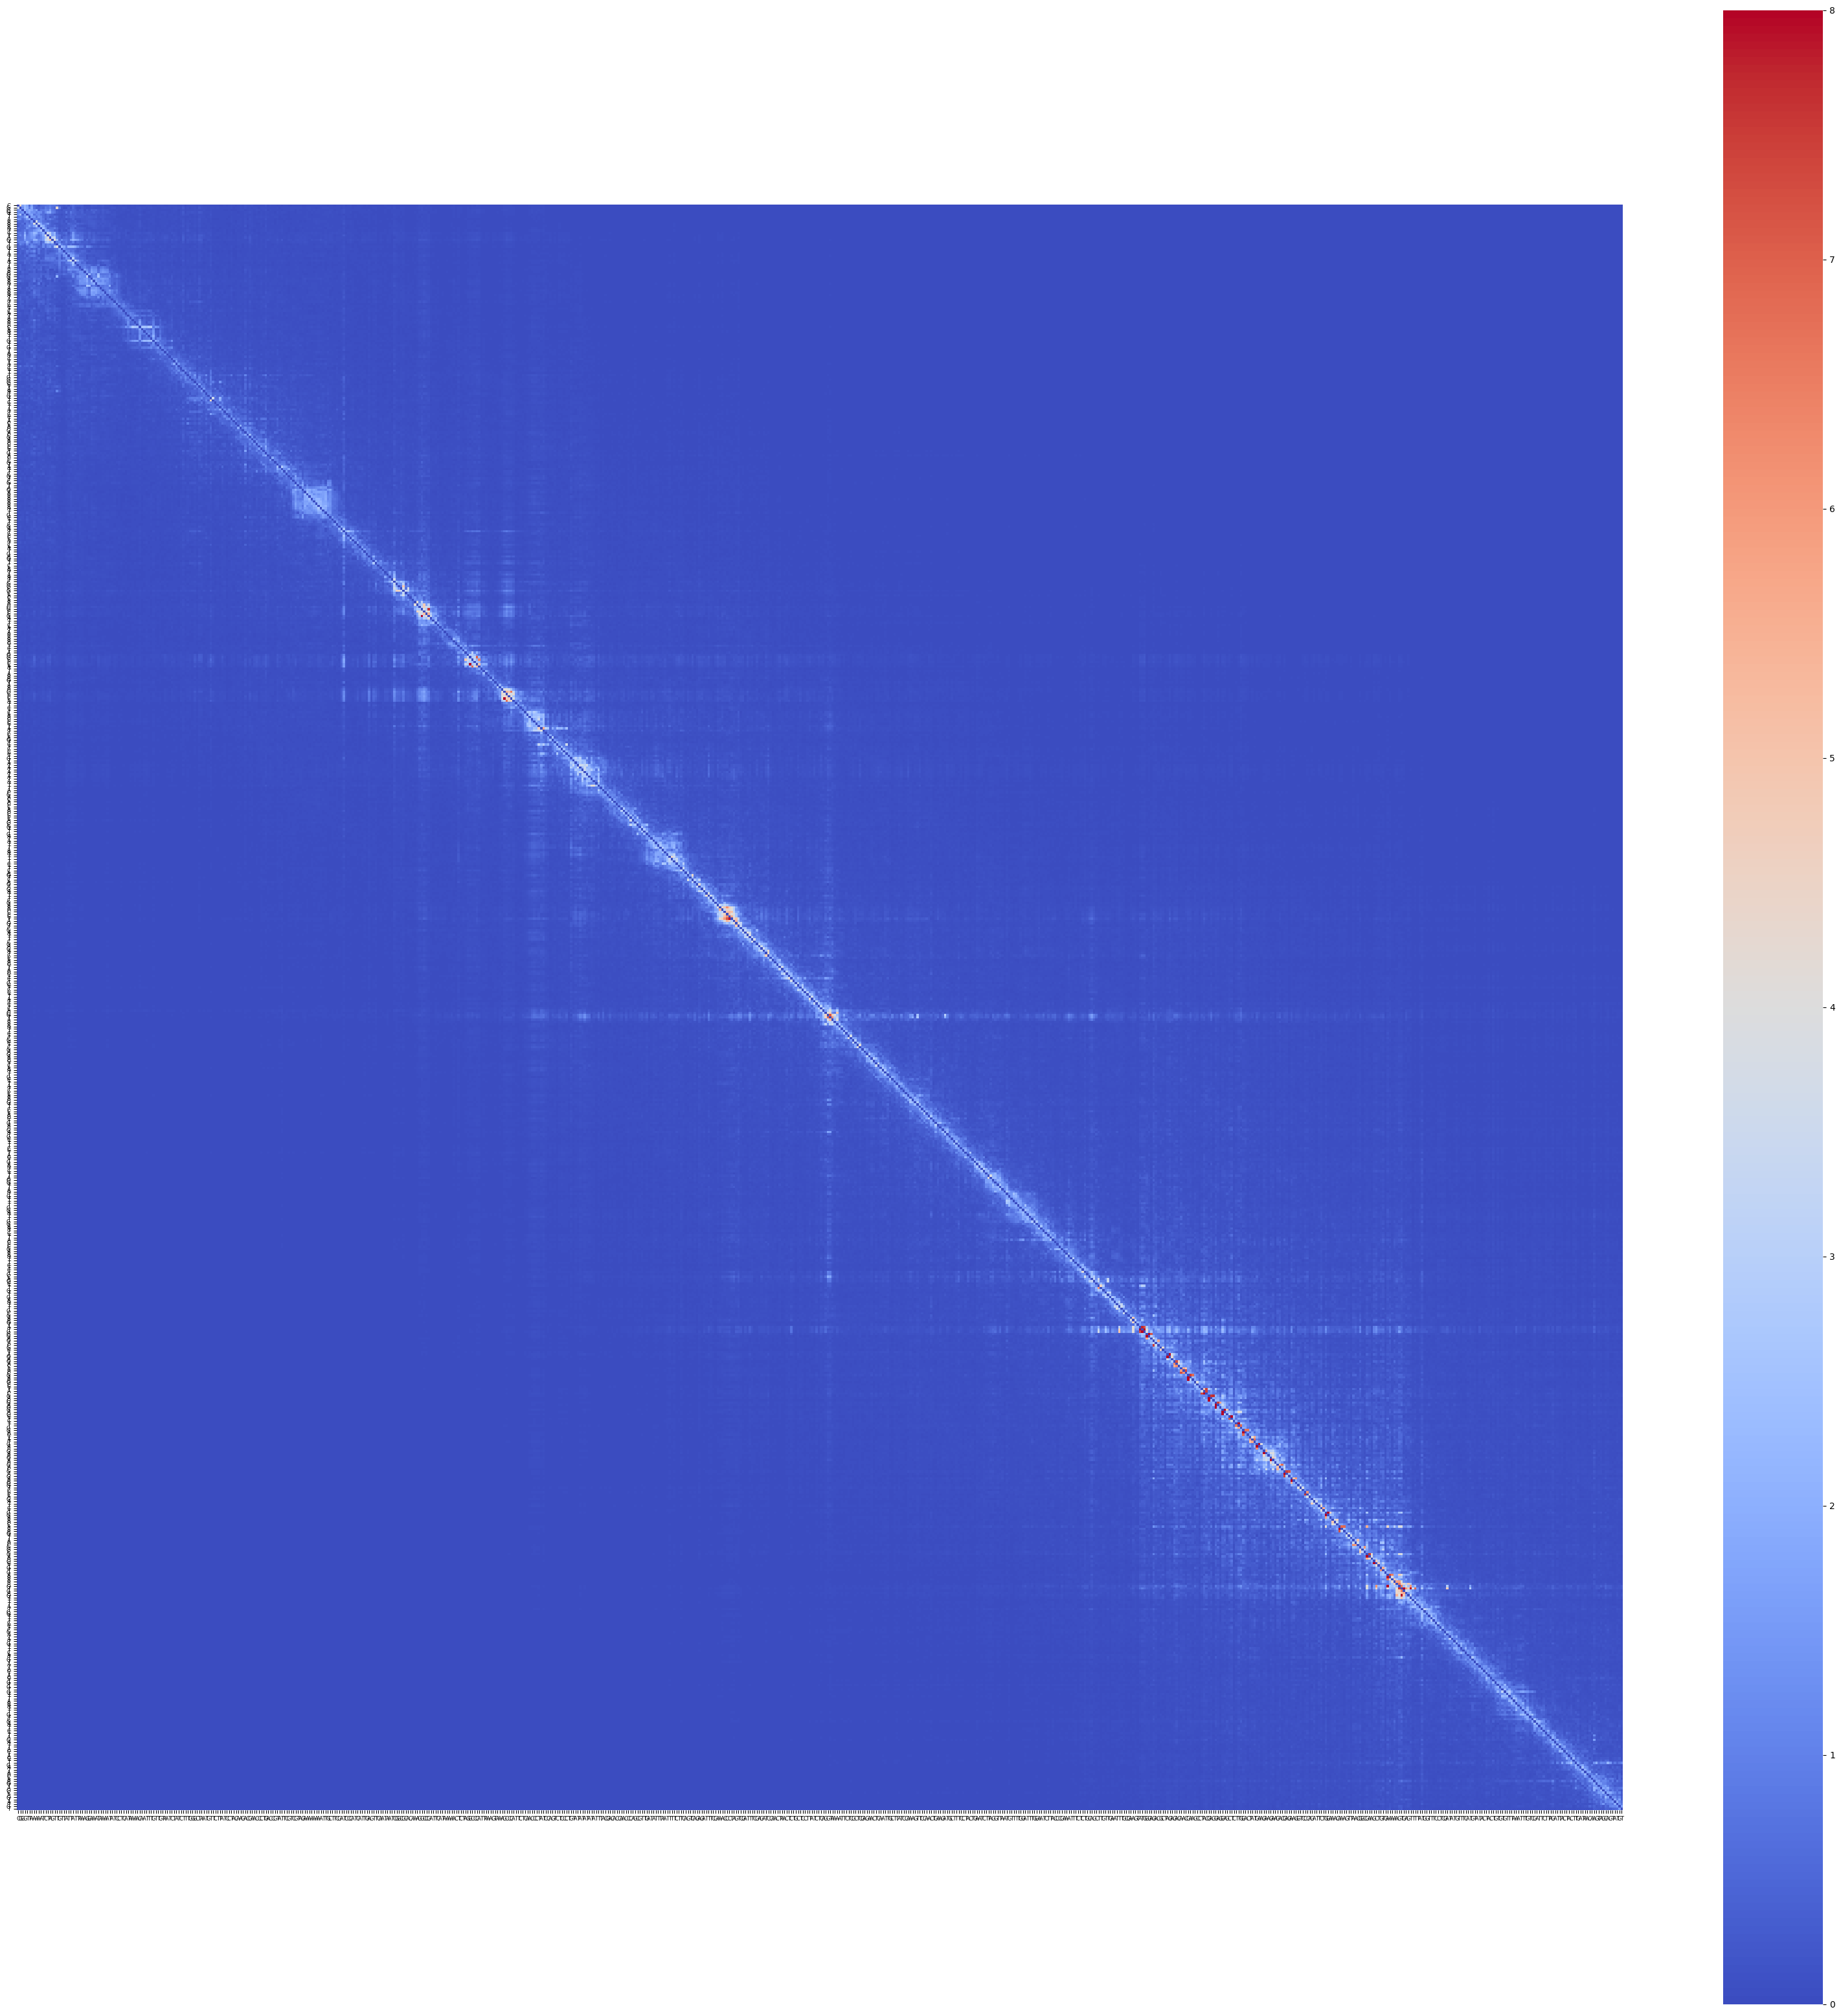

In [77]:
plot_map_with_seq(dep_map, seq, vmax=8, tick_label_fontsize=6, plot_size=40)